# Armaan Kapoor, ECE-464, PS2 (Web Scraping)
---

In this PS I will scrape the popular ecommerce clothing market **Grailed**. Specializing in streetwear, **Grailed** is one of the go to destinations for 'hype-beasts' from around the world.

We naviagate to ```www.grailed.com``` and search for the iconic term "Supreme". The goal is to create a database of all item listings that match this keyword. 

Grailed only renders enough items to occupy roughly one page of the active browser window. When a user scrolls to the bottom of the page new listings are dynamically rendered.

- **Data Extraction Details**: The script uses Selenium's `find_elements` method to locate and interact with specific elements on the **Grailed** webpage. For each item listing, it captures the following details:
  - Name: Extracted from the text content of elements matching the CSS selector `".ListingMetadata-module__title___Rsj55"`.
  - Price: Obtained from elements with the CSS selector `".Price-module__onSale___1pIHp"`, reflecting the current sale price.
  - Image URL: Sourced from the `src` attribute of `img` tags within elements having the CSS selector `".listing-cover-photo img"`, providing a link to the item's thumbnail image.
  - Link: The URL to the item's detail page is retrieved from the `href` attribute of anchor elements (`a`) with the class `listing-item-link`.

- **Output File Structure**: The scraped data is structured into a CSV file in the ```scraped_item_listings``` containing columns for `Name`, `Price`, `Image URL`, and `Link`.



In [91]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import requests
from PIL import Image
from sklearn.cluster import KMeans
from tqdm import tqdm

grailed = pd.read_csv("scraped_item_listings/grailed_long.csv")
grailed_2 = pd.read_csv("scraped_item_listings/grailed_long_2.csv")
grailed = pd.concat([grailed, grailed_2])
df = grailed.drop_duplicates()

The cell above reads in the data gathered from a 100s session with a conservative wait schedule.

In [92]:
df.head()

,Name,Price,Image URL,Link
0,SUPREME x Hanes/plain thin t-shirt/29239 - 867 50,$90,https://media-assets.grailed.com/prd/listing/t...,https://www.grailed.com/listings/58373041-hane...
1,The north face,$162,https://media-assets.grailed.com/prd/listing/t...,https://www.grailed.com/listings/57996108-supr...
2,Supreme Hanes Boxer Brief in fluorescent yello...,$22,https://media-assets.grailed.com/prd/listing/4...,https://www.grailed.com/listings/44737363-hane...
3,Vintage Supreme King Tubby distressed Tee Shirt,$145,https://media-assets.grailed.com/prd/listing/3...,https://www.grailed.com/listings/57810032-stre...
4,Supreme Loose Gauge Beanie Kaki O/S (one size),$89,https://media-assets.grailed.com/prd/listing/3...,https://www.grailed.com/listings/58386680-supr...


The next cell gets raw image data from each item using requests and PIL. It is commented out since the precomputed df is read from a pkl file.

In [93]:
# def image_to_array(image_url):
#     response = requests.get(image_url)
#     if response.status_code == 200:
#         image = Image.open(BytesIO(response.content))
#         return np.array(image)
#     else:
#         print(f"Failed to download image from {image_url}")
#         return None


# # Add a new column with the image data as numpy arrays
# df["Image Data"] = df["Image URL"].apply(image_to_array)

In [94]:
# read in scraped_item_listings/grailed_with_images.pkl
df = pd.read_pickle("scraped_item_listings/grailed_with_images.pkl")

In [95]:
# Preprocess images: resize, convert to RGB, and flatten
processed_images = []
for img_array in tqdm(df['Image Data'], desc='Processing images'):
    if img_array is not None:
        # Convert to RGB and resize image to a common size (e.g., 64x64)
        img = Image.fromarray(img_array)
        img = img.convert('RGB').resize((64, 64))
        # Flatten the image to a 1D array
        processed_images.append(np.array(img).flatten())

# Ensure all images are converted and resized uniformly
if processed_images:
    image_matrix = np.vstack(processed_images)

    # Perform K-means clustering
    num_clusters = 4  # define the number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(image_matrix)

    # Add cluster labels to the dataframe
    df['Cluster'] = np.nan  # Initialize column with NaNs
    df.loc[df['Image Data'].notnull(), 'Cluster'] = kmeans.labels_

Processing images: 100%|██████████| 541/541 [00:09<00:00, 60.09it/s]  
/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_49379/607686417.py:22: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Cleanup and ETL

In [96]:
# Price col currently has $163 converted to 163
df["Price"] = df["Price"].str.replace("$", "").astype(float)

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_49379/4167366572.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



#### Visualize Clusters

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_49379/4008259909.py:6: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



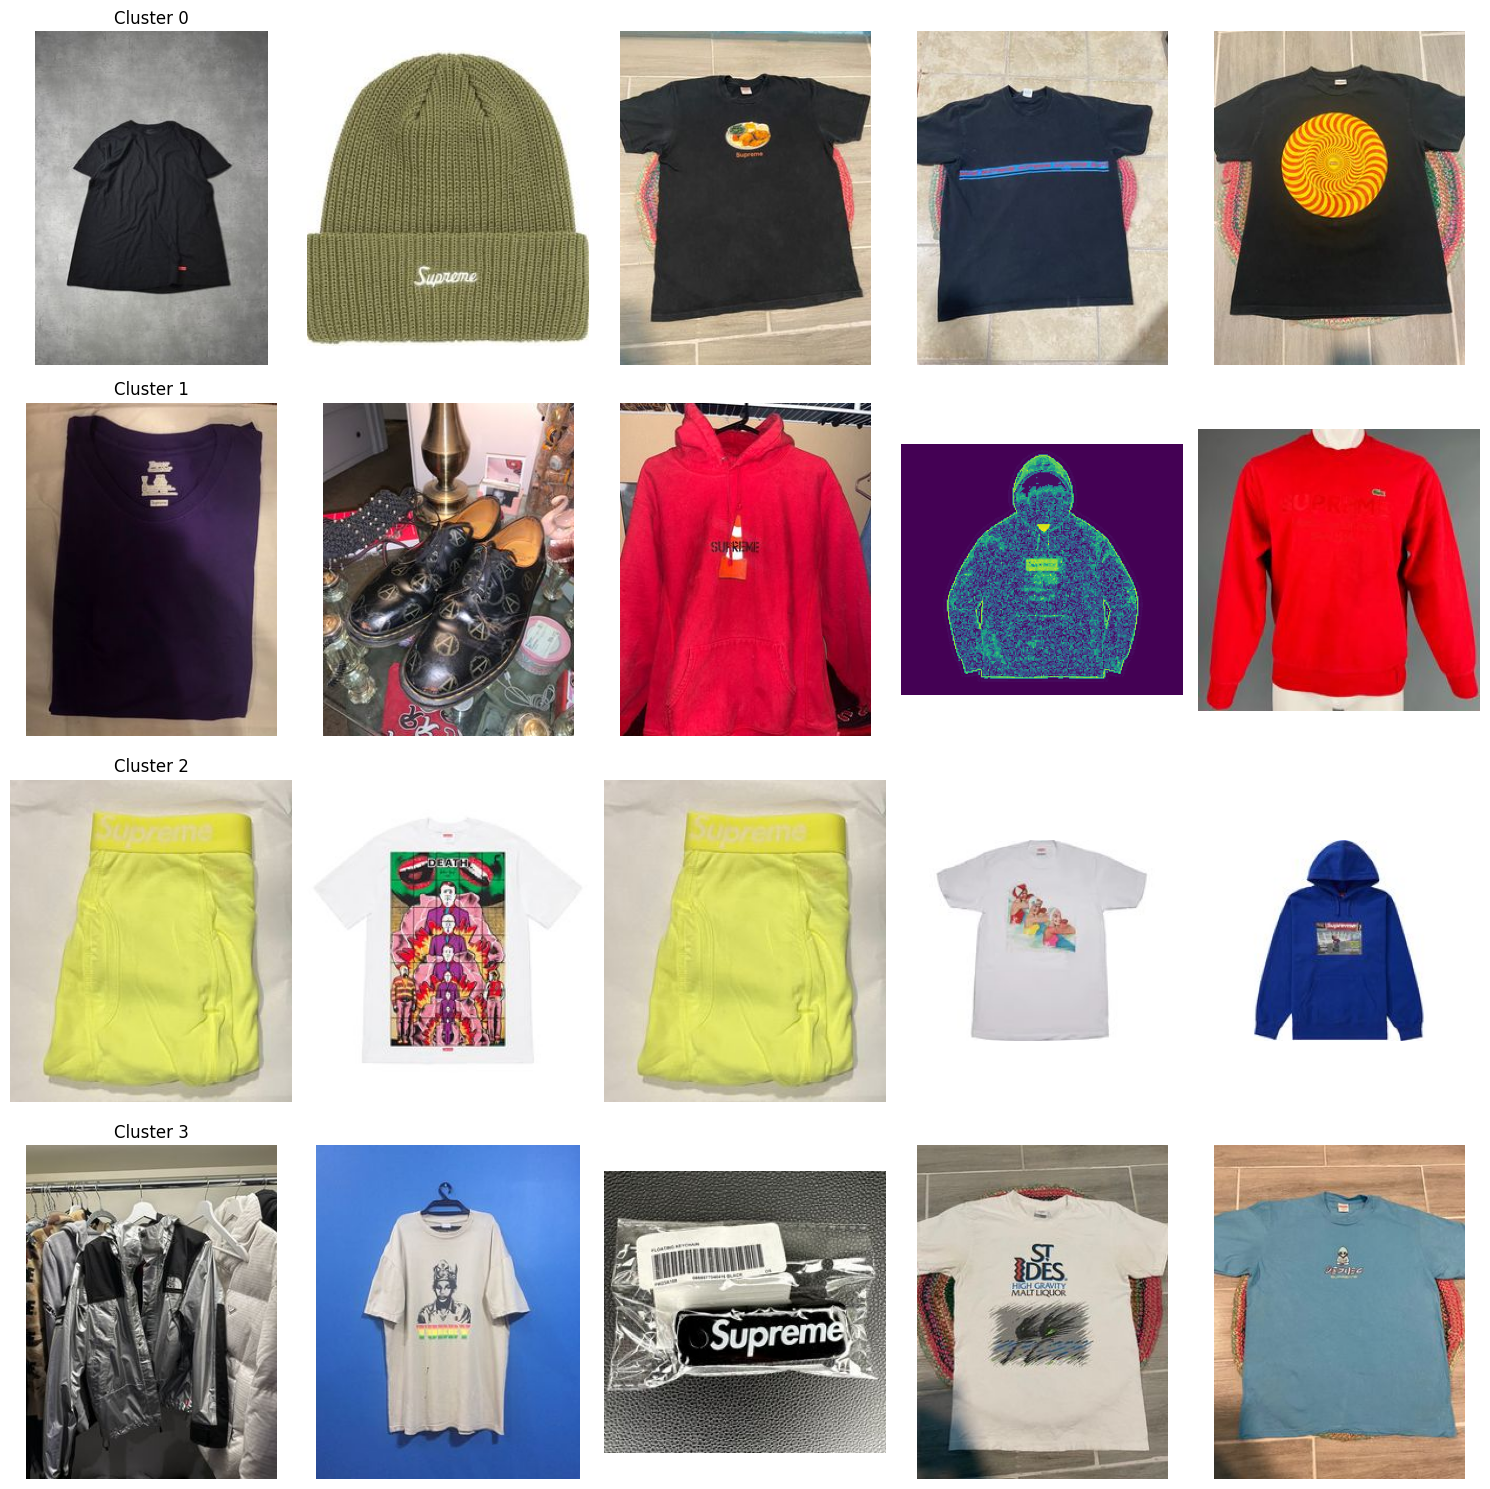

In [97]:
images_per_cluster = 5

fig, axs = plt.subplots(num_clusters, images_per_cluster, figsize=(15, 15))

for cluster in range(num_clusters):
    cluster_images = df[df['Cluster'] == cluster]['Image Data'][:images_per_cluster]
    for i, image_data in enumerate(cluster_images):
        img = Image.fromarray(image_data)
        axs[cluster, i].imshow(img)
        axs[cluster, i].axis('off')  # Hide the axes
        if i == 0:
            axs[cluster, i].set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.show()


In [98]:
import plotly.graph_objs as go
import pandas as pd
import plotly.express as px

df['Price Numeric'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df['Name Length'] = df['Name'].apply(len)

num_clusters = df['Cluster'].nunique()

# Create the price histogram for each cluster
fig = go.Figure()
for i in range(num_clusters):
    cluster_data = df[df['Cluster'] == i]
    fig.add_trace(go.Histogram(x=cluster_data['Price Numeric'], name=f'Cluster {i}'))

fig.update_layout(
    title_text='Price Distribution by Cluster',
    xaxis_title_text='Price ($)',
    yaxis_title_text='Count',
    barmode='overlay'
)
fig.update_traces(opacity=0.65)  # Reduce the opacity to see both histograms

fig2 = px.pie(df, names='Cluster', title='Item Count per Cluster')

fig3 = px.scatter(df, x='Name Length', y='Price Numeric', color='Cluster', 
                  title='Name Length vs Price', labels={'Cluster': 'Cluster'})

fig.show()
fig2.show()
fig3.show()
